In [1]:
# Install OS dependencies.  This only needs to be run once for each new notebook instance.
!pip install PyAthena

In [2]:
from pyathena import connect
from pyathena.util import as_pandas
from __future__ import print_function

# Import libraries
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import *
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.multiclass
from itertools import cycle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import interp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams.update({'font.size': 12})
import os
import boto3
from botocore.client import ClientError
# below is used to print out pretty pandas dataframes
from IPython.display import display, HTML
%matplotlib inline


s3 = boto3.resource('s3')
client = boto3.client("sts")
account_id = client.get_caller_identity()["Account"]
my_session = boto3.session.Session()
region = my_session.region_name
athena_query_results_bucket = 'aws-athena-query-results-'+account_id+'-'+region

try:
    s3.meta.client.head_bucket(Bucket=athena_query_results_bucket)
except ClientError:
    bucket = s3.create_bucket(Bucket=athena_query_results_bucket)
    print('Creating bucket '+athena_query_results_bucket)
cursor = connect(s3_staging_dir='s3://'+athena_query_results_bucket+'/athena/temp').cursor()


# The Glue database name of your MIMIC-III parquet data
gluedatabase="mimiciii"

# location of the queries to generate aline specific materialized views
aline_path = './'

# location of the queries to generate materialized views from the MIMIC code repository
concepts_path = './concepts/'

In [3]:
unseen_label = "__New__"
seed = 200

class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.le = LabelEncoder()
        self.lb = LabelBinarizer()
        self.seen_labels = set()
        
    def fit(self, x, y=None,**fit_params):
        self.seen_labels = set(x)
        self.seen_labels.add(unseen_label)
        
        # add "unseen" to X
        x_new = list(x)
        x_new.append(unseen_label)

        label_encoded = self.le.fit_transform(x_new)
        self.lb.fit(label_encoded)
        return self
    
    def transform(self, x):
        x_new = list(map(lambda label: label if label in self.seen_labels else unseen_label, list(x)))
        label_encoded = self.le.transform(x_new)
        return self.lb.transform(label_encoded)
    
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key]

    
class MultiItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key_list):
        self.key_list = key_list

    def fit(self, x, y=None):
        return self
    
    def transform(self, df):
        return df[self.key_list]

In [4]:
def descretize(x, cutoff1, cutoff2):
    if x < cutoff1:
        return 0
    elif x < cutoff2:
        return 1
    else: 
        return 2

def evaluate(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision_micro = precision_score(y_true, y_pred, average='micro')
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1score_micro = f1_score(y_true, y_pred, average='micro')   
    f1score_macro = f1_score(y_true, y_pred, average='macro')  
    print ("Accuracy : {:.4f}".format(acc))
    print("Precision (Micro) : {:.4f}".format(precision_micro))
    print("Precision (Macro): {:.4f}".format(precision_macro))
    print("Recall (Micro) : {:.4f}".format(recall_micro))
    print("Recall (Macro): {:.4f}".format(recall_macro))
    print("F1 score (Micro) : {:.4f}".format(f1score_micro))
    print("F1 score (Macro): {:.4f}".format(f1score_macro))
    print("\nClassification report : \n", classification_report(y_true, y_pred))
    print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))

In [5]:
def train_evaluate_model(df):
    # set cutoff for multiclass labels
    cutoff1 = 24
    cutoff2 = 24*7
    

    df_dead = df[(df.hospital_expire_flag==1) ]
    print(df.shape, df_dead.shape)
    
    # split data into 80% training set, 20% test set
    train_cv_df = df_dead.sample(frac=0.8,random_state=seed)
    test_df = df_dead.drop(train_cv_df.index)
    print('Train-test split: ', train_cv_df.shape, test_df.shape)
    
    # define the machine learning pipeline
    discrete_pipeline = Pipeline([
        ("feature_union", FeatureUnion(
            transformer_list=[
                # categorical pipeline
                ('ethnicity', Pipeline([
                    ("selector", ItemSelector(key='ethnicity')),
                    ("binarizer", CustomLabelBinarizer())
                ])),            

                ("gender", Pipeline([
                    ("selector", ItemSelector(key='gender')),
                    ("binarizer", CustomLabelBinarizer())
                ])),
                ("admission_type", Pipeline([
                    ("selector", ItemSelector(key='admission_type')),
                    ("binarizer", CustomLabelBinarizer())
                ])),
                # numerical pipeline
                ("numerical", Pipeline([
                    ("selector", MultiItemSelector(key_list=
                          ['age', 'icustay_num',
                           'heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
                           'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean', 
                           'heartrate_min', 'sysbp_min', 'diasbp_min','meanbp_min', 
                           'resprate_min', 'tempc_min', 'spo2_min', 'glucose_min',
                           'heartrate_max', 'sysbp_max', 'diasbp_max', 'meanbp_max',
                           'resprate_max', 'tempc_max', 'spo2_max', 'glucose_max', 
                           'gcs_mean', 'gcsmotor_mean', 'gcsverbal_mean', 'gcseyes_mean', 'endotrachflag_mean',
                           'gcs_min', 'gcsmotor_min', 'gcsverbal_min', 'gcseyes_min', 'endotrachflag_min', 
                           'gcs_max', 'gcsmotor_max', 'gcsverbal_max', 'gcseyes_max', 'endotrachflag_max',  
                           'po2_mean', 'pco2_mean', 'ph_mean',  'totalco2_mean', 
                           'aniongap_mean',   'bicarbonate_mean', 
                            'creatinine_mean', 'chloride_mean', 
                           'hematocrit_mean', 'hemoglobin_mean',  'platelet_mean', 
                           'potassium_mean', 'ptt_mean', 'inr_mean', 'sodium_mean', 'bun_mean', 'wbc_mean',
                           'po2_min', 'pco2_min', 'ph_min',  'totalco2_min',
                           'aniongap_min',   'bicarbonate_min',
                            'creatinine_min', 'chloride_min',
                           'hematocrit_min', 'hemoglobin_min',  'platelet_min',
                           'potassium_min', 'ptt_min', 'inr_min', 'sodium_min', 'bun_min', 'wbc_min', 
                           'po2_max', 'pco2_max', 'ph_max',  'totalco2_max',          
                           'aniongap_max',  'bicarbonate_max', 
                            'creatinine_max', 'chloride_max', 
                           'hematocrit_max', 'hemoglobin_max',  'platelet_max', 
                           'potassium_max', 'ptt_max', 'inr_max', 'sodium_max', 'bun_max', 'wbc_max', 
                           'urineoutput'])),
                    # impute missing values with median
                    ("imputer", SimpleImputer(strategy="median")),
                ]))

            ]
        )),
        ("algorithm", RandomForestClassifier(n_jobs=-1))
    ])

    # define the parameter grid
    parameters = {'algorithm__n_estimators': [100, 250, 500],
                  'algorithm__max_features': ["auto", "sqrt", "log2"],
                  "algorithm__criterion": ["gini", "entropy"],
                  "algorithm__max_depth": [5, 10, 30],
                  "algorithm__bootstrap": [True, False]}

    # grid search on 5-fold CV, trained on 80% training set
    # note that we have also transformed hosp_deathtime_hours to 3 classes using descretize()
    grid_search = GridSearchCV(discrete_pipeline, parameters, n_jobs=-1, verbose=1, refit=True, cv=5, scoring='f1_micro')
    grid_search.fit(train_cv_df, train_cv_df.deathtime_hours.map(lambda x: descretize(x, cutoff1, cutoff2)))

    # retrieve the best parameter set from grid search
    print("\nGrid Search Best parameters set :")
    print(grid_search.best_params_)
    print("\nBest score: %0.3f" % grid_search.best_score_)
    
    
    # evaluate model performance
    print("\nEvaluation on Test Set (20%) :")
    test_actual = test_df.deathtime_hours.map(lambda x: descretize(x, cutoff1, cutoff2))
    test_pred = grid_search.predict(test_df)
    evaluate(test_actual, test_pred)
    
    # compute prediction proba (y_score) and actual label (y_test) on test set
    # they will be used for plotting ROC curves later
    ohc = OneHotEncoder()
    y_test = ohc.fit_transform(test_actual.values.reshape(-1,1)).todense()
    y_score = grid_search.predict_proba(test_df)
    print(y_test.shape, y_score.shape)
    
    return grid_search, y_test, y_score

In [6]:
df_6hr=pd.read_csv('./Data/ICU_6hr_df.csv')
df_12hr=pd.read_csv('./Data/ICU_12hr_df.csv')
df_18hr=pd.read_csv('./Data/ICU_18hr_df.csv')

In [7]:
# fit the pipeline using 6-hour data
grid_search_6hr, y_test_6hr, y_score_6hr = train_evaluate_model(df_6hr)

(38739, 104) (4783, 104)
Train-test split:  (3826, 104) (957, 104)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 32.1min finished



Grid Search Best parameters set :
{'algorithm__bootstrap': True, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 10, 'algorithm__max_features': 'sqrt', 'algorithm__n_estimators': 500}

Best score: 0.536

Evaluation on Test Set (20%) :
Accuracy : 0.5131
Precision (Micro) : 0.5131
Precision (Macro): 0.5517
Recall (Micro) : 0.5131
Recall (Macro): 0.4776
F1 score (Micro) : 0.5131
F1 score (Macro): 0.4841

Classification report : 
               precision    recall  f1-score   support

           0       0.66      0.29      0.40       191
           1       0.48      0.43      0.46       392
           2       0.51      0.71      0.59       374

   micro avg       0.51      0.51      0.51       957
   macro avg       0.55      0.48      0.48       957
weighted avg       0.53      0.51      0.50       957


Confusion matrix : 
 [[ 55  83  53]
 [ 19 170 203]
 [  9  99 266]]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(957, 3) (957, 3)


In [8]:
# fit the pipeline using 12-hour data
grid_search_12hr, y_test_12hr, y_score_12hr = train_evaluate_model(df_12hr)

(45800, 110) (5342, 110)
Train-test split:  (4274, 110) (1068, 110)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 36.6min finished



Grid Search Best parameters set :
{'algorithm__bootstrap': True, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 30, 'algorithm__max_features': 'sqrt', 'algorithm__n_estimators': 500}

Best score: 0.551

Evaluation on Test Set (20%) :
Accuracy : 0.5618
Precision (Micro) : 0.5618
Precision (Macro): 0.5781
Recall (Micro) : 0.5618
Recall (Macro): 0.5211
F1 score (Micro) : 0.5618
F1 score (Macro): 0.5384

Classification report : 
               precision    recall  f1-score   support

           0       0.62      0.37      0.46       165
           1       0.52      0.56      0.54       450
           2       0.59      0.63      0.61       453

   micro avg       0.56      0.56      0.56      1068
   macro avg       0.58      0.52      0.54      1068
weighted avg       0.57      0.56      0.56      1068


Confusion matrix : 
 [[ 61  83  21]
 [ 21 254 175]
 [ 16 152 285]]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(1068, 3) (1068, 3)


In [9]:
# fit the pipeline using 18-hour data
grid_search_18hr, y_test_18hr, y_score_18hr = train_evaluate_model(df_18hr)

(47899, 110) (5466, 110)
Train-test split:  (4373, 110) (1093, 110)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  8.6min
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 38.1min finished



Grid Search Best parameters set :
{'algorithm__bootstrap': False, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 30, 'algorithm__max_features': 'sqrt', 'algorithm__n_estimators': 500}

Best score: 0.570

Evaluation on Test Set (20%) :
Accuracy : 0.5764
Precision (Micro) : 0.5764
Precision (Macro): 0.6246
Recall (Micro) : 0.5764
Recall (Macro): 0.5687
F1 score (Micro) : 0.5764
F1 score (Macro): 0.5885

Classification report : 
               precision    recall  f1-score   support

           0       0.78      0.53      0.63       204
           1       0.51      0.57      0.54       439
           2       0.58      0.60      0.59       450

   micro avg       0.58      0.58      0.58      1093
   macro avg       0.62      0.57      0.59      1093
weighted avg       0.59      0.58      0.58      1093


Confusion matrix : 
 [[109  69  26]
 [ 23 249 167]
 [  8 170 272]]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(1093, 3) (1093, 3)


In [10]:
def plot_roc(y_test, y_score, plot_title, filepath) :
    
    # compute fpr, tpr and auc for each class respectively
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # compute micro-average fpr, tpr and auc
    fpr["micro"], tpr["micro"], _ = roc_curve(np.array(y_test).ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
   # compute macro-average fpr, tpr and auc
    n_classes = 3
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # plot all ROC curves
    lw = 2
    fig = plt.figure()
    fig.set_size_inches(8,7)
    plt.plot(fpr["micro"], tpr["micro"],\
             label='micro-average ROC curve (area = {0:0.2f})'\
             ''.format(roc_auc["micro"]),\
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],\
             label='macro-average ROC curve (area = {0:0.2f})'\
                   ''.format(roc_auc["macro"]),\
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,\
                 label='ROC curve of class {0} (area = {1:0.2f})'\
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_title)
    plt.legend(loc="lower right")
    fig.savefig(filepath)
    plt.show()

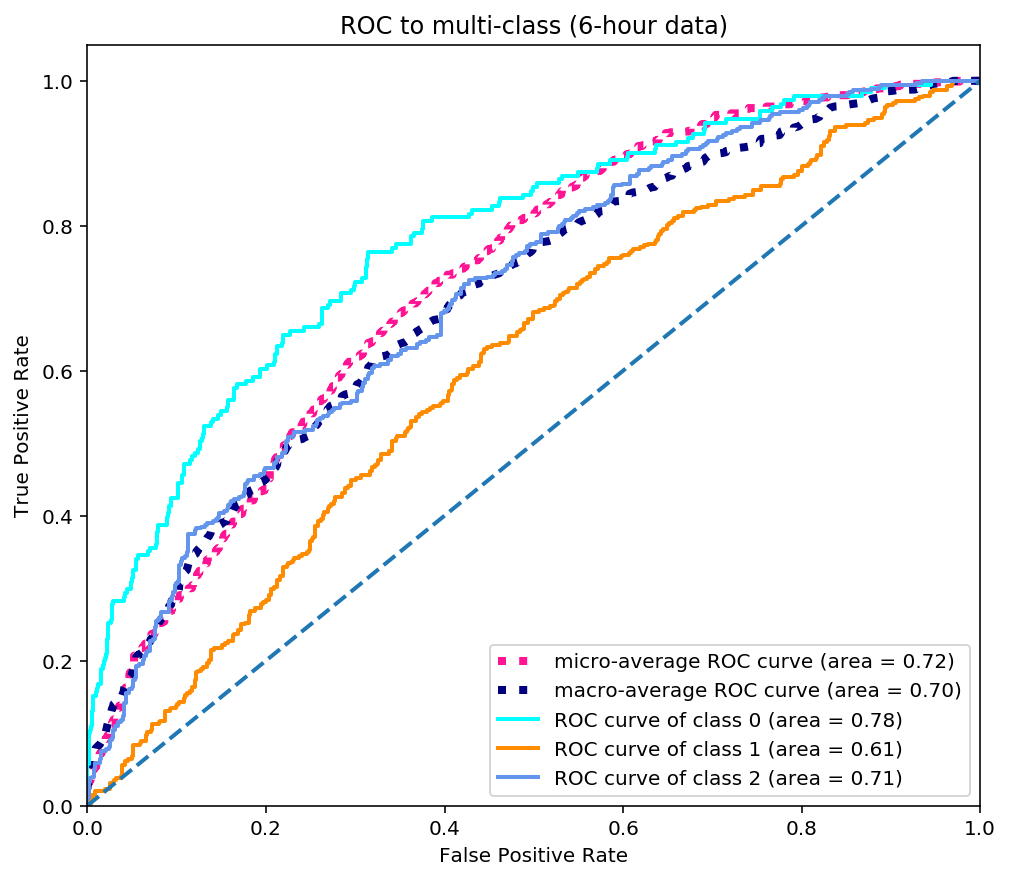

In [11]:
# plot ROC curves for 6-hour data
plot_roc(y_test_6hr, y_score_6hr, 
         plot_title='ROC to multi-class (6-hour data)', filepath='./img/figure3.png')

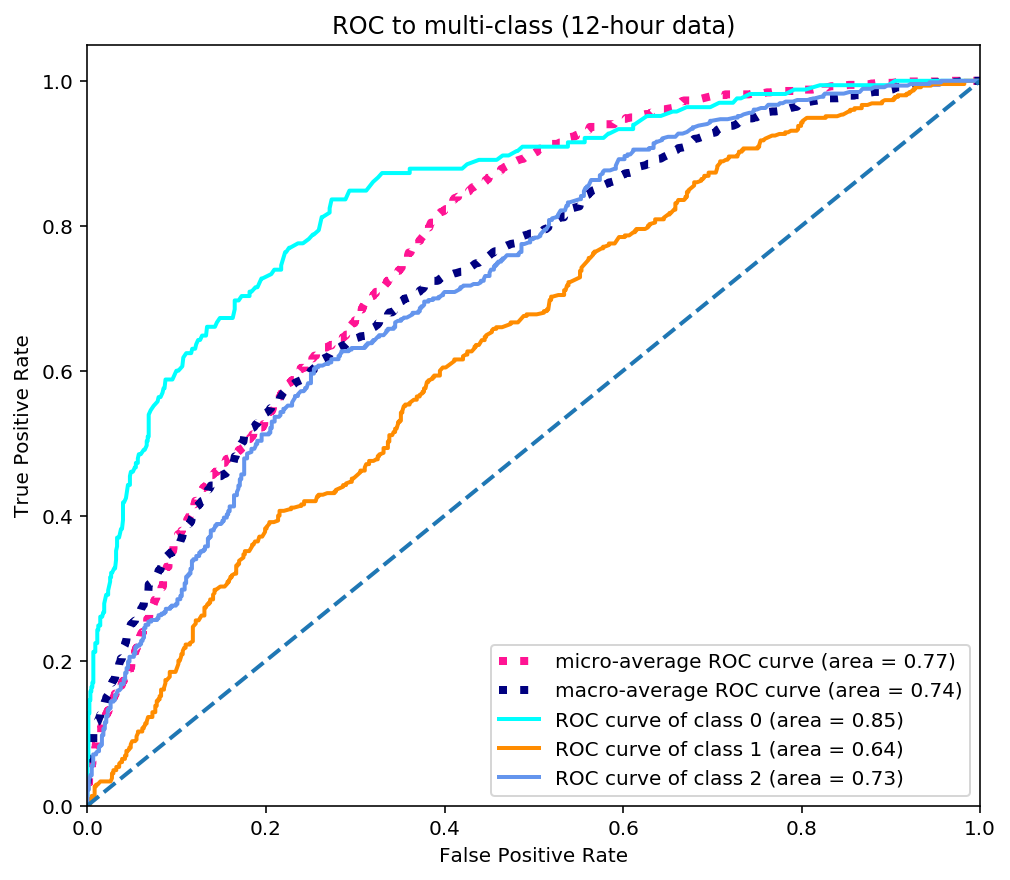

In [12]:
# plot ROC curves for 12-hour data
plot_roc(y_test_12hr, y_score_12hr, 
         plot_title='ROC to multi-class (12-hour data)', filepath='./img/figure4.png')

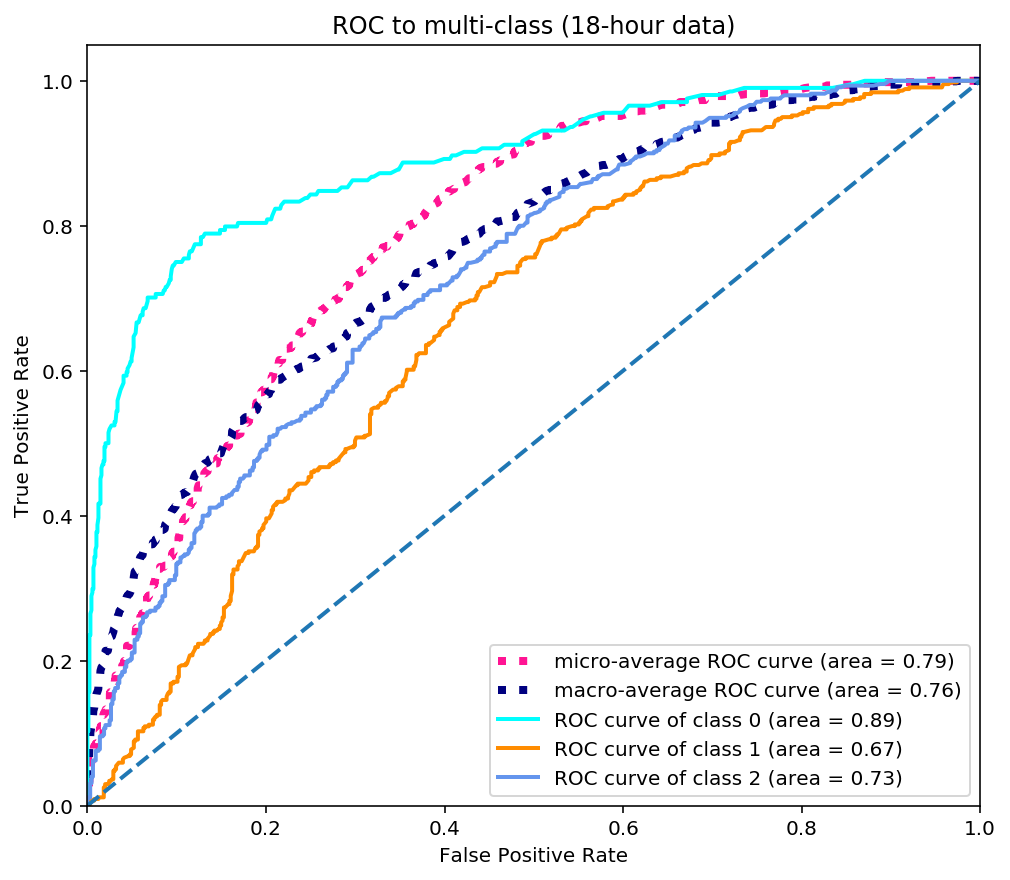

In [13]:
# plot ROC curves for 18-hour data
plot_roc(y_test_18hr, y_score_18hr, 
         plot_title='ROC to multi-class (18-hour data)', filepath='./img/figure5.png')